In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import seaborn as sns

from os.path import join

plt.style.use(["seaborn", "thesis"])

/home/jo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
plt.rc("figure", figsize=(8,4))

# Fetch Dataset 

In [3]:
from SCFInitialGuess.utilities.dataset import extract_triu_batch, AbstractDataset
from sklearn.model_selection import train_test_split

data_path = "../../dataset/TSmall_sto3g"
postfix = "TSmall_sto3g"
dim = 26
data_path = "../../dataset/EthenT/"
postfix = "EthenT"
dim = 72
basis = "6-311++g**"
n_electrons = 16
#data_path = "../butadien/data/"
#postfix = ""
#dim = 26


def split(x, y, ind):
    return x[:ind], y[:ind], x[ind:], y[ind:]

S = np.load(join(data_path, "S" + postfix + ".npy"))
P = np.load(join(data_path, "P" + postfix + ".npy"))

index = np.load(join(data_path, "index" + postfix + ".npy"))

molecules = np.load(join(data_path, "molecules" + postfix + ".npy"))


ind = int(0.8 * len(index))
ind_val = int(0.8 * ind)


molecules = (
    molecules[:ind_val], 
    molecules[ind_val:ind], 
    molecules[ind:]
)

#s_triu_norm, mu, std = AbstractDataset.normalize(S)


s_train, p_train, s_test, p_test = split(S, P, ind)
s_train, p_train, s_val, p_val = split(s_train, p_train, ind_val)



In [4]:
from SCFInitialGuess.utilities.dataset import make_center_block_dataset
from SCFInitialGuess.descriptors.high_level import AtomicNumberWeighted
from SCFInitialGuess.descriptors.cutoffs import BehlerCutoff1
from SCFInitialGuess.descriptors.models import RADIAL_GAUSSIAN_MODELS
from SCFInitialGuess.descriptors.coordinate_descriptors import \
    Gaussians, SPHAngularDescriptor

descriptor = AtomicNumberWeighted(
    Gaussians(*RADIAL_GAUSSIAN_MODELS["Man"]),
    SPHAngularDescriptor(15),
    BehlerCutoff1(5)
)
    
    


# Utilities 

## Calculate Descriptors and extract center blocks 

## Networks 

In [ ]:
#keras.backend.clear_session()

#activation = "elu"
#learning_rate = 1e-5

intializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.01)

def make_model(
        structure, 
        input_dim, 
        output_dim,
        activation="elu", 
        learning_rate=1e-3
    ):

    model = keras.Sequential()

    # input layer
    model.add(keras.layers.Dense(
        structure[0], 
        activation=activation, 
        input_dim=input_dim, 
        kernel_initializer=intializer
    ))

    for layer in structure[1:]:
        model.add(keras.layers.Dense(
            layer, 
            activation=activation, 
            #kernel_initializer=intializer, 
            #bias_initializer='zeros',
            kernel_regularizer=keras.regularizers.l2(1e-6)
        ))

    #output
    model.add(keras.layers.Dense(output_dim))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate), 
        loss='MSE', 
        metrics=['mae', 'mse']
    )
    
    return model



In [6]:
path = "../../models/ParticleNumberIndependent/CenterBlocks/"

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_mean_squared_error", 
    min_delta=1e-10, 
    patience=200, 
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_mean_squared_error', 
    factor=0.5, 
    patience=50, 
    verbose=1, 
    mode='auto', 
    min_delta=1e-6, 
    cooldown=50, 
    min_lr=1e-10
)



epochs = 1000


def train_model(model, dataset, filepath, learning_rate=1e-4):
    
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, 
        monitor='val_mean_squared_error', 
        verbose=1, 
        save_best_only=True, 
        save_weights_only=False, 
        mode='auto', 
        period=1
    )
    
    error = []
    while True:
        keras.backend.set_value(model.optimizer.lr, learning_rate)
            
        history = model.fit(
            x = dataset.training[0],
            y = dataset.training[1],
            epochs=epochs,
            shuffle=True,
            validation_data=dataset.validation, 
            verbose=1, 
            callbacks=[
                early_stopping, 
                reduce_lr,
                checkpoint
            ]
        )

        error.append(model.evaluate(
            dataset.testing[0], 
            dataset.testing[1], 
            verbose=1
        )[1])
    
    return error
    

# C  

## Compute inputs 

In [8]:
name_C = "model_C_" + postfix + ".h5"


In [ ]:


dataset_C = make_center_block_dataset(
    descriptor,
    molecules,
    (p_train, p_val, p_test),
    "C"
)

In [ ]:
from SCFInitialGuess.utilities.constants import number_of_basis_functions as N_BASIS


species = "C"

dim_C = N_BASIS[basis][species]
dim_C_triu = dim_C * (dim_C + 1) // 2


In [ ]:
descriptor.number_of_descriptors, dim_C_triu

In [ ]:
structure_C = [450, 350, 300]

In [ ]:
keras.backend.clear_session()

In [ ]:
model_C = make_model(
    structure=structure_C,
    input_dim=descriptor.number_of_descriptors,
    output_dim=dim_C_triu
)

model_C.summary()

In [ ]:

train_model(
    model_C, 
    dataset_C, 
    path + name_C,
    learning_rate=1e-4
)

#  H

In [9]:
name_H = "model_H_" + postfix + ".h5"

In [ ]:
dataset_H = make_center_block_dataset(
    descriptor,
    molecules,
    (p_train, p_val, p_test),
    "H"
)

In [ ]:
species = "H"
dim_H = N_BASIS[basis][species]
dim_H_triu = dim_H * (dim_H + 1) // 2

descriptor.number_of_descriptors, dim_H_triu

In [ ]:
structure_H = [250, 100, 50]

In [ ]:
model_H = make_model(
    structure=structure_H,
    input_dim=descriptor.number_of_descriptors,
    output_dim=dim_H_triu
)

model_H.summary()

In [ ]:


train_model(
    model_H, 
    dataset_H,
    path + name_H,
    learning_rate=1e-3
)

# Test the Guess

In [10]:
model_C = keras.models.load_model(path + name_C)
model_H = keras.models.load_model(path + name_H)

networks = {
    "C": model_C,
    "H": model_H
}

In [23]:
from SCFInitialGuess.utilities.dataset import reconstruct_from_triu
from SCFInitialGuess.utilities.constants import number_of_basis_functions as N_BASIS
from pyscf.scf.hf import init_guess_by_wolfsberg_helmholtz


def init_guess_by_ann(mol, descriptor):
    
    p  = init_guess_by_wolfsberg_helmholtz(mol.get_pyscf_molecule()).copy() # TODO set up my own GWH in SCFInitialGuess
    
    for atom_index, atom in enumerate(mol.species):
        
        mask = mol.make_atom_mask(atom_index)
        
        
        G = descriptor.calculate_atom_descriptor(
            atom_index, 
            mol,
            descriptor.number_of_descriptors
        )
        
        #f(G)
        f = networks[atom].predict(G.reshape(1, -1))
        
        f_batch = reconstruct_from_triu(
            f,
            N_BASIS[mol.basis][atom]
        )
        
        p[mask] = f_batch.flatten()
        
    return p
        
    

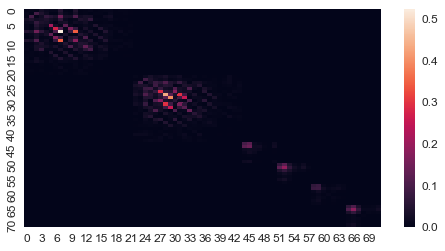

In [25]:
sns.heatmap(np.abs(init_guess_by_ann(molecules[2][0], descriptor) \
                   - init_guess_by_wolfsberg_helmholtz(molecules[2][0].get_pyscf_molecule())))

In [27]:
p_nn = np.array([
    init_guess_by_ann(mol, descriptor) for mol in molecules[2]
])

## Analysis 

In [28]:
from SCFInitialGuess.utilities.dataset import StaticDataset

dataset = StaticDataset(
    #train=(s_train, p_train),
    train=(None, None),
    validation=(None, None),
    test=(s_test, p_test),
    mu=0,
    std=1
)

In [30]:
from SCFInitialGuess.utilities.analysis import \
    make_results_str, measure_all_quantities, mf_initializer


print(make_results_str(measure_all_quantities(
    p_nn,
    dataset,
    molecules[2],
    n_electrons,
    mf_initializer,
    dim=dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2018-11-12 22:47:00: Iteration calculation: 0
[ ] 2018-11-12 22:47:01: Iteration calculation: 1
[ ] 2018-11-12 22:47:02: Iteration calculation: 2
[ ] 2018-11-12 22:47:02: Iteration calculation: 3
[ ] 2018-11-12 22:47:03: Iteration calculation: 4
[ ] 2018-11-12 22:47:04: Iteration calculation: 5
[ ] 2018-11-12 22:47:05: Iteration calculation: 6
[ ] 2018-11-12 22:47:05: Iteration calculation: 7
[ ] 2018-11-12 22:47:06: Iteration calculation: 8
[ ] 2018-11-12 22:47:06: Iteration calculation: 9
[ ] 2018-11-12 22:47:07: Iteration calculation: 10
[ ] 2018-11-12 22:47:07: Iteration calculation: 11
[ ] 2018-11-12 22:47:08: Iteration calculation: 12
[ ] 2018-11-12 22:47:08: Iteration calculation: 13
[ ] 2018-11-12 22:47:09: Iteration calculation: 14
[ ] 2018-11-12 22:47:10: Iteration calculation: 15
[ ] 2018-11-12 22:47:10: Iteration calculation: 16
[ ] 2018-11-12 22:47:11: Iteration calculation: 17
[ ] 2018-11-12 22:47:11: Iteration calculation: 18
[ ] 2018-11-12 22:47:12: Iteration calcul

[ ] 2018-11-12 22:48:43: Iteration calculation: 160
[ ] 2018-11-12 22:48:44: Iteration calculation: 161
[ ] 2018-11-12 22:48:44: Iteration calculation: 162
[ ] 2018-11-12 22:48:45: Iteration calculation: 163
[ ] 2018-11-12 22:48:46: Iteration calculation: 164
[ ] 2018-11-12 22:48:47: Iteration calculation: 165
[ ] 2018-11-12 22:48:47: Iteration calculation: 166
[ ] 2018-11-12 22:48:48: Iteration calculation: 167
[ ] 2018-11-12 22:48:49: Iteration calculation: 168
[ ] 2018-11-12 22:48:49: Iteration calculation: 169
[ ] 2018-11-12 22:48:50: Iteration calculation: 170
[ ] 2018-11-12 22:48:50: Iteration calculation: 171
[ ] 2018-11-12 22:48:51: Iteration calculation: 172
[ ] 2018-11-12 22:48:52: Iteration calculation: 173
[ ] 2018-11-12 22:48:53: Iteration calculation: 174
[ ] 2018-11-12 22:48:53: Iteration calculation: 175
[ ] 2018-11-12 22:48:54: Iteration calculation: 176
[ ] 2018-11-12 22:48:55: Iteration calculation: 177
[ ] 2018-11-12 22:48:55: Iteration calculation: 178
[ ] 2018-11-